In [1]:
include("../reconstruction_probability.jl")

reconstruction_probability (generic function with 1 method)


The energy of this model is defined as follows:

$$ E = - \frac{1}{\lambda} log \left( \sum_{\mu = 1}^{P} exp( \lambda \xi^\mu \cdot x) \right), $$
where the factor $ \xi^\mu \cdot x $ is the overlap between the $\mu$-th original pattern and the configuration x. <br>

Now, if we change the sign of the $k$-th spin, we obtain that the overlap variation is:
$$  
\Delta overlap = overlap_{fin} - overlap_{in} = \left(\sum_{i \neq k}\xi_i^\mu x_i + \xi_k^\mu (-x_k)\right) - \left(\sum_{i \neq k}\xi_i^\mu x_i + \xi_k^\mu x_k\right)\\
= -2\xi_{k}^{\mu}x_k  $$.

Thus, the variation in the energy can be calculated as:
$$ \Delta E \equiv E_f - E_i = - \frac{1}{\lambda} log \left( \sum_{\mu = 1}^{P} exp( \lambda \cdot overlap_{in}^\mu) \right)
+ \frac{1}{\lambda} log \left( \sum_{\mu = 1}^{P} exp( \lambda \cdot overlap_{fin}^\mu) \right)\\
= - \frac{1}{\lambda} \left[log \left(\sum_{\mu = 1}^{P} exp(\lambda \cdot overlap_{fin}^\mu \right)
- log \left(\sum_{\mu = 1}^{P} exp(\lambda \cdot overlap_{in}^\mu \right)\right]\\
= -\frac{1}{\lambda} \left[ log \left( \frac{\sum_{\mu = 1}^{P} exp(\lambda \cdot overlap_{fin}^\mu)}{\sum_{\mu = 1}^{P} exp(\lambda \cdot overlap_{in}^\mu)} \right) \right].
$$
We have that:
$$ overlap_{fin}^\mu = overlap_{in}^\mu - 2\xi_{k}^{\mu}x_k. $$
Hence:
$$\Delta E =  -\frac{1}{\lambda} \left[ log \left( \frac{\sum_{\mu = 1}^{P} exp(\lambda \cdot overlap_{in}^\mu)exp(-2\lambda\xi_{k}^{\mu}x_k) }{\sum_{\mu = 1}^{P} exp(\lambda \cdot overlap_{in}^\mu)} \right) \right] $$

@time begin
    N = 100
    α = 0.1
    M = round(Int, N * α)
    p = 0.2
    ξ = generate_patterns(M, N)
    σ = perturb(ξ[:, 1], p)
    nsweeps = 100
    overlaps = zeros(nsweeps)
    
    for sweep in 1:nsweeps
        σ, fliprate = metropolis(σ, ξ)
        overlaps[sweep] = overlap(σ, ξ[:,1])/N
        fliprate <= 0 && break
    end

end

function metro(N::Int, M::Int, σ::AbstractVector, ξ::AbstractMatrix, β = 10)

    fliprate = 0

    for n in 1:N
        i = rand(1:N)
        ΔE = 0
        for μ in 1:M
            orig_ξ = ξ[:, μ]
            overlap_in = overlap( orig_ξ, σ )
            ΔE -= exp( overlap_in ) * ( exp( -2 * orig_ξ[i] * σ[i] ) - 1 )
        end

        if ΔE < 0 || rand() < exp( - β * ΔE)
            σ[i] *= -1
            fliprate += 1
        end
    end
    
    return σ, fliprate/N
end


function reconstruction_prob(N::Int, pp::AbstractVector, α, nsweeps,
                             nsamples, β = 10, earlystop = 0)
    M = round(Int, N * α)
    
    len_pp = length(pp)
    probs = zeros(len_pp)
    error_bars = zeros(len_pp)
    magnetization = zeros(len_pp)
    
    for i in 1:len_pp
        probs_over_samples = zeros(nsamples)        
        #count = 0
        ms = zeros(nsamples)
        
        for sample in 1:nsamples
            ξ = generate_patterns(M, N)
            
            k = rand(1:M)
            σ = ξ[:, k]
            perturbed_σ = perturb(σ, pp[i])
                        
            perturbed_σ = monte_carlo(perturbed_σ, ξ, nsweeps, earlystop, β)
            
            m = overlap(perturbed_σ, σ)
            #print(m)
            if m >= N * 0.98
                probs_over_samples[sample] = 1
                #count += 1
            end
            ms[sample] = m
        end
        probs[i] = Statistics.mean(probs_over_samples)
        error_bars[i] = Statistics.std(probs_over_samples)/sqrt(nsamples)
        magnetization[i] = Statistics.mean(ms)
    end
    
    return probs, error_bars, magnetization
end
        

NN = [50, 100]
pp = range( 0.1, 0.7, length = 25 )
α = 0.1
nsweeps = 20
β = 10^3
nsamples = 1500
earlystop = 0

for i in 1:length(NN)
    N = NN[i]
    p, e, m = reconstruction_prob(N, pp, α, nsweeps, nsamples, β, earlystop)
    
    fig = plot(pp, p, size = (500,300), markershape =:circle, label = "N = $N, α = $α",
        yerrors = e, xlabel = "p", ylabel = "P_reconst") 
    display(fig)
    
    #io = open("julia_data/alpha_01/probsN"*"$N"*".txt", "w") do io
     #     writedlm(io, [p e m])
    #end
end

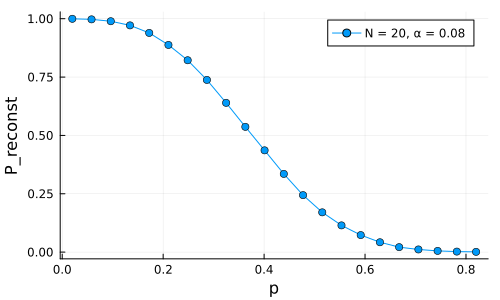

 43.788940 seconds (301.23 M allocations: 30.186 GiB, 9.39% gc time)


In [4]:
NN = [20] 
α = 0.08
pp = range(0.02, 0.82, length = 22)
@time reconstruction_probability(NN, α; pp = pp, show = true, save = false, 
    nsamples = 10^5, thr = 0.8, β = 10)

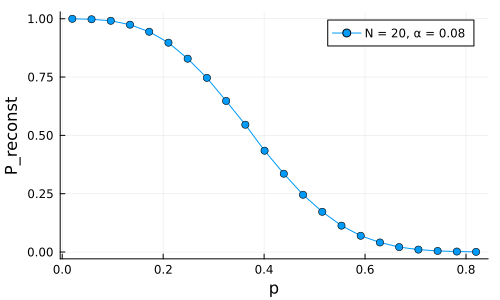

 40.469033 seconds (297.08 M allocations: 29.807 GiB, 10.17% gc time)


In [8]:
NN = [20] 
α = 0.08
pp = range(0.02, 0.82, length = 22)
@time reconstruction_probability(NN, α; pp = pp, show = true, save = false, 
    nsamples = 10^5, thr = 0.8, β = 10^8)

In [66]:
pp = readdlm("../julia_data/reconstruction_prob/alpha_100/probsN30.txt")[:,1]
p50 = readdlm("../julia_data/reconstruction_prob/alpha_100/probsN30.txt")[:,2]
e50 = readdlm("../julia_data/reconstruction_prob/alpha_100/probsN30.txt")[:,3]

LoadError: ArgumentError: Cannot open '../julia_data/reconstruction_prob/alpha_100/probsN30.txt': not a file

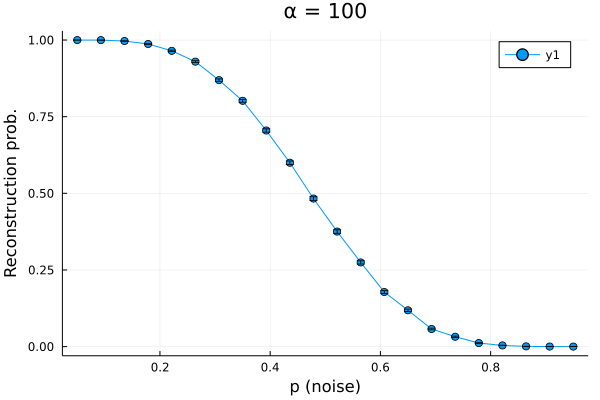

In [35]:
fig = plot(pp, p50, markershape =:circle, yerrors = e50,
    xlabel = "p (noise)", ylabel = "Reconstruction prob.",
    title = "α = 100")

In [9]:
x = [1,2,3,4,5,6]

6-element Vector{Int64}:
 1
 2
 3
 4
 5
 6

In [10]:
MHB.logsumexp(x)

6.456193316018123

In [11]:
function lse1(x)
    imax = argmax(x)
    a = x[imax]
    s = 0
    N = length(x)
    w = zeros(N)
    for i in 1:N
        w[i] = exp(x[i] - a)
        if i != imax
            s += w[i]
        end
    end
    f = a + log1p(s)
    return f
end

lse1 (generic function with 1 method)

In [12]:
lse1(x)

6.456193316018123

In [52]:
t = 10000
overlaps = zeros(t)
N = 20
α = 0.1
M = round(Int, exp(N*α))
for i in 1:t
    ξ = MHB.generate_patterns(M, N)
    σ = ξ[:, 1]
    σ_pert = MHB.perturb(σ, 0.6)
    σ_rec = MHB.monte_carlo(σ_pert, ξ)
    overlaps[i] = MHB.overlap(σ_rec, σ)/N
end

In [2]:
a = [1,2,3,4,5]
b = [0.1, 0.2, 0.01, 0.02, 0.04]

5-element Vector{Float64}:
 0.1
 0.2
 0.01
 0.02
 0.04

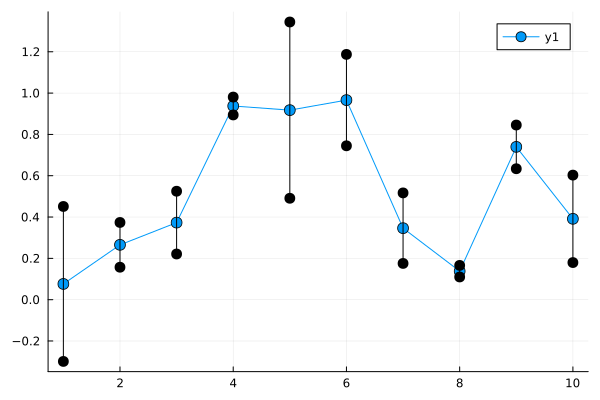

In [3]:
plot(rand(10), yerror = abs.(randn(10)./4), ms =6, markershape =:circle)

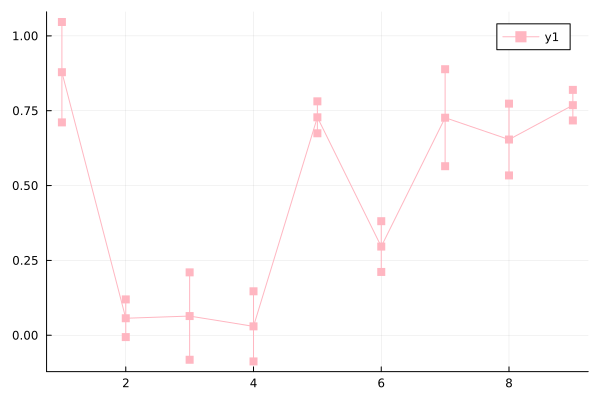

In [9]:
using Plots
y1, y2 = rand(9), rand(9)
dy1, dy2 = 0.2rand(9), 0.2rand(9)
plot(y1, yerror=dy1, m=:square, lc=:reds, mc=:reds, msc=:reds)
